# Two Metronome Model

## Required imports

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from pandas import DataFrame

## Constants & Parameters

In [6]:
# Constants
g = 9.81                            # Gravity (m/s^2)

# Metronome Parameters
#m_pendulum = 0.1                    # Mass of pendulum (kg)
L1_pendulum = 0.3                   # Length of first pendulum (m)
L2_pendulum = 0.3                   # Length of second pendulum (m)
epsilon = 0.15                      # Escapement force coefficient
theta1_0_init=theta1_0 = 0.9        # Initial position of metronome 1
theta2_0_init=theta2_0 = 0.25       # Initial position of metronome 2

# Surface Parameters (Coupling)
M_surface = 1.0                     # Mass of the surface (kg)
B_surface = 0                     # Surface damping coefficient
K_surface = 0.5                     # Surface stiffness

# Initial Conditions (Angles in radians)
omega1_0 = 0.0                      # Initial angular velocity
omega2_0 = 0.0                      # Initial angular velocity
x_0 = 0.0                           # Initial displacement of the surface
v_0 = 0.0                           # Initial velocity of the surface

# Cart Parameters
#M_cart = 1.0                        # Mass of the cart (kg)
B_cart = 0                       # Damping coefficient
K_cart = 0.5                        # Stiffness of the cart

## Two metronome model

In [7]:
def metronome_matrix_system(t, y, M_cart, m_pendulum):
    # Unpack state variables
    theta1, omega1, theta2, omega2, x, v = y  

    I1 = m_pendulum * L1_pendulum**2    # Inertia of first pendulum
    I2 = m_pendulum * L2_pendulum**2    # Inertia of second pendulum


    # Mass Matrix M(q)
    M_q = np.array([
        [I1, 0, m_pendulum * L1_pendulum * np.cos(theta1)],
        [0, I2, m_pendulum * L2_pendulum * np.cos(theta2)],
        [m_pendulum * L1_pendulum * np.cos(theta1), m_pendulum * L2_pendulum * np.cos(theta2), M_cart + 2 * m_pendulum]
    ])

    # Coriolis and Damping Matrix C(q, q_dot)
    C_q_qdot = np.array([
        [epsilon * ((theta1 / theta1_0)**2 - 1) * m_pendulum*(L1_pendulum**2), 0, 0],
        [0, epsilon * ((theta2 / theta2_0)**2 - 1) *m_pendulum*(L2_pendulum**2) , 0],
        [m_pendulum * L1_pendulum * np.sin(theta1) * omega1, m_pendulum * L2_pendulum * np.sin(theta2) * omega2, 0]
    ])

    # Gravity Matrix G(q)
    G_q = np.array([
        [m_pendulum * g * L1_pendulum * np.sin(theta1)],
        [m_pendulum * g * L2_pendulum * np.sin(theta2)],
        [0]     # No gravitational force directly on the cart
    ])


    Tau = np.array([[0],[0],[0] ]) # External force on the cart 

    # Solve for accelerations: M(q) * q_ddot + C(q, q_dot) * q_dot + G(q)=Tau
    q_ddot = np.linalg.solve(M_q, (Tau - np.dot(C_q_qdot, np.array([[omega1], [omega2], [v]])) - G_q))

    return [omega1, q_ddot[0, 0], omega2, q_ddot[1, 0], v, q_ddot[2, 0]]

## Model solver

In [8]:
class solver():
    """
    solver object for the feedback linearisation control

    stores the feedback derivative gain, proportional gain and all results in the model
    """
    def __init__(self, M_cart, m_pendulum, T_max=50):
        """
        set up the solver with an input kd, kp and t_max
        """
        self.M_cart = M_cart
        self. m_pendulum = m_pendulum
        self.T_max = T_max

        # set up the attributes for the model object to fill
        self.time = []
        self.theta1 = []
        self.qdd1 = []
        self.theta2 = []
        self.qdd2 = []
        self.surface_x = []
        self.qdd3 = []

        self.sync_time = -1
        self.sync_threshold = -1
        self.energy_plot = []
        self.system_energy = -1

    def solve(self, dt=0.01):
        """
        solve the ode with scipy.integrate.solve_ivp(), retrieve the results and fill the model objects attributes

        Args:
            dt (float, optional): change in time for integrator. Defaults to 0.01.

        Returns:
            solver object: model object     # probably unnecessary tbh
        """
        t_span = (0, self.T_max)
        y0 = [theta1_0_init, omega1_0, theta2_0_init, omega2_0, x_0, v_0]
        t_eval = np.arange(0, self.T_max, dt)

        sol = solve_ivp(metronome_matrix_system, t_span, y0, args=[self.M_cart, self.m_pendulum], t_eval=t_eval, method="RK45")

        # Extract solutions
        self.time = sol.t                # time
        self.theta1 = sol.y[0]           # angle of metronome 1
        self.qdd1 = sol.y[1]             # acceleration of metronome 1
        self.theta2 = sol.y[2]           # angle of metronome 1
        self.qdd2 = sol.y[3]             # acceleration of metronome 2
        self.surface_x = sol.y[4]        # Surface displacement
        self.qdd3 = sol.y[5]             # acceleration of cart

        return self

    def find_sync_time(self, sync_threshold=1.0):
        """
        find the sync time for the metronomes to a set accuracy or lower - if accuracy cannot be 
        reached, reduce by 0.05 until an accuracy is reached. records both time and accuracy.

        sync is determined if the average value of the phase diff of the two metronomes for the prior 3 seconds
        are within the threshold synchronicity set. returns the value of 3 seconds ago where the sync began

        Args:
            sync_threshold (float, optional): sync threshold (0 - 1). Defaults to 1.0.

        Returns:
            floats: threshold, time to sync     
            # redundant since the model attributes are filled anyway, left for compatability with old code
        """
        sync = False
        while not sync:
            for t in range(300, len(self.time)):
                phase_diff = np.abs(self.theta1[t-300:t] - self.theta2[t-300:t])
                avg_sync = np.mean(1 - phase_diff)

                # adjust this to increase threshold for synchronicity
                if avg_sync >= sync_threshold:
                    #print(f"Synched at {self.time[t-300]} with synch {avg_sync}")
                    sync = True
                    self.sync_time = self.time[t-300]
                    self.sync_threshold = sync_threshold
                    return sync_threshold, self.time[t-300]
                
            sync_threshold -= 0.05

    def calc_energy(self,M_cart,m_pendulum ):
        """
        calculate the energy of a flc system of two metronomes with given input kd and kp

        calculates the energy as a combination of kinetic of both metronomes and cart + gpe from
        both metronomes using standard formula / predefined formula

        Returns:
            _type_: model, sync time, total energy (array)
        """

        # calc kinetic energy of metronomes
        # ke = 1/2 * I * omega**2
        # I = m * L**2
        # so ke = 1/2 * m * L**2 * omega**2
        ke_1 = 1/2 * m_pendulum * L1_pendulum**2 * self.qdd1**2
        ke_2 = 1/2 * m_pendulum * L2_pendulum**2 * self.qdd2**2

        # calc kinetic energy of cart
        # ke = 1/2 * m * v**2
        ke_3 = 1/2 * M_cart * self.qdd3**2

        total_ke = ke_1 + ke_2 + ke_3

        # calc gpe of metronomes
        # gpe = m * g * h
        # h = L * cos (theta)abs(
        gpe_1 = m_pendulum * g * L1_pendulum * np.cos(self.theta1)
        gpe_2 = m_pendulum * g * L2_pendulum * np.cos(self.theta2)

        total_gpe = gpe_1 + gpe_2

        # total energy
        total_energy = total_ke + total_gpe

        self.energy_plot = total_energy
        self.system_energy = np.sum(np.abs(total_energy))

MAsses effects on synchronisation

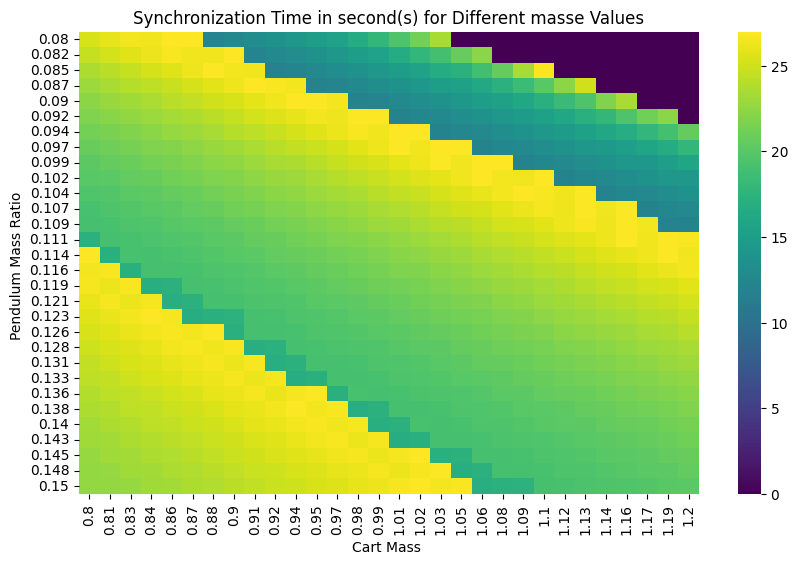

In [9]:
import seaborn as sns
import numpy as np 

m_pendelums = np.linspace(0.08, 0.15, 30)  # Fixed pendulum mass
m_carts = np.linspace(0.8, 1.2, 30)  # Generate 30 values for kd

sync_times_matrix = np.zeros((len(m_pendelums), len(m_carts)))  # Matrix to store sync times

for i, m in enumerate(m_pendelums):
    for j, M in enumerate(m_carts):
        model = solver(M, m, 30)  # Create the model
        model.solve()  # Solve the system
        sync_time = model.find_sync_time(sync_threshold=0.91)[1]  # Get synchronization time
        sync_times_matrix[i, j] = sync_time

# Create heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(sync_times_matrix, xticklabels=np.round(m_carts, 2), yticklabels=np.round(m_pendelums, 3), cmap="viridis", cbar=True)

# Labels and title
plt.xlabel("Cart Mass ")
plt.ylabel("Pendulum Mass Ratio ")
plt.title("Synchronization Time in second(s) for Different masse Values")
plt.show()
